# Introducing Distributed Word Vectors

- 단순 요약하자면 Word2vec은 2013년 구글에서 발표되었고, neural network를 적용한 알고리즘이다. 다른 RNN같은 알고리즘에 비해서 학습시간이 굉장히 짧고 Word2vec은 따로 label을 정의하지 않아도 된다. 
- 원래는 C로 짜여진 알고리즘이며 여러 다른 언어로 변환되어 사용되고 있다.


# Using word2vec in Python
- python에서는 gensim 이라는 패키지를 통해서 사용할 수 있다. 따로 GPU를 사용하지 않으며 Google's version과 Python version 모두 multi-threading 사용이 가능하다. 시간을 단축시키고 싶다면 cython을 설치하면 된다.

# Reference

- ratsgo님의 블로그 포스팅: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/30/word2vec/
- 오늘코드의 프로그래밍 강의: https://programmers.co.kr/learn/courses/21/lessons/1698

# Preparing to Train a Model

In [149]:
# preprocessing
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

# functions KaggleWord2VecUtility 
from KaggleWord2VecUtility import KaggleWord2VecUtility

# multiprocessing 
from multiprocessing import Pool

# functions defs 위 KaggleWord2VecUtility와 같음
import defs

# word2vec
from gensim.models import word2vec

# graphs
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [7]:
# Read data from files 
train = pd.read_csv( "../dataset/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "../dataset/testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "../dataset/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print("Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews\n" % (train["review"].size, test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [3]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

이전과 같이 nltk에서 punkt를 사용하기 위해서는 nltk.download('punkt')를 해주어야한다.

In [4]:
# nltk.download('punkt')

In [4]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, remove_stopwords ))
    
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

위에서 정의한 함수를 통해서 Word2vec에 들어갈 input 데이터를 만든다.

In [16]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set
Parsing sentences from unlabeled set


In [17]:
print(len(sentences))
print('sentences[0]: ',sentences[0])
print('sentences[1]: ',sentences[1])

795538
sentences[0]:  ['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']
sentences[1]:  ['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']


KaggleWord2VecUtility를 통해서 전처리하는게 시간이 더 많이 걸린다.

In [43]:
sentences_stem = []
for review in train["review"]:
    sentences_stem += KaggleWord2VecUtility.review_to_sentences(review, remove_stopwords=False)
    
for review in unlabeled_train["review"]:
    sentences_stem += KaggleWord2VecUtility.review_to_sentences(review, remove_stopwords=False)

In [44]:
print(len(sentences_stem))
print('sentences_stem[0]: ',sentences_stem[0])
print('sentences_stem[1]: ',sentences_stem[1])

795538
sentences_stem[0]:  ['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'start', 'listen', 'to', 'his', 'music', 'watch', 'the', 'odd', 'documentari', 'here', 'and', 'there', 'watch', 'the', 'wiz', 'and', 'watch', 'moonwalk', 'again']
sentences_stem[1]:  ['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'realli', 'cool', 'in', 'the', 'eighti', 'just', 'to', 'mayb', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilti', 'or', 'innoc']


remove_stopwords 대신 tokenizer를 잘못 넣은 적이 있는데 bs4 관련 애러가 발생했다. 그래서 remove_stopwords가 True로 인식되면 에러가 생기는 것인지 확인했지만 잘 동작했다. bs4 관련 에러에 대한 문제는 정확히 잘 모르겠다.
- 아래는 상민이에게 발생한 에러메세지   
![](../images/error2.png)

In [44]:
# sentences = []
# for review in train["review"]:
#     sentences += KaggleWord2VecUtility.review_to_sentences(review, remove_stopwords=True)
    
# for review in unlabeled_train["review"]:
#     sentences += KaggleWord2VecUtility.review_to_sentences(review, remove_stopwords=True)

In [48]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, 
                          size=num_features, min_count = min_word_count,
                          window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "../saved_model/300features_40minwords_10context"
model.save(model_name)

2019-05-26 22:29:31,294 : INFO : collecting all words and their counts
2019-05-26 22:29:31,294 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-05-26 22:29:31,333 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2019-05-26 22:29:31,366 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
2019-05-26 22:29:31,400 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types
2019-05-26 22:29:31,433 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
2019-05-26 22:29:31,464 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types


Training model...


2019-05-26 22:29:31,500 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
2019-05-26 22:29:31,534 : INFO : PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
2019-05-26 22:29:31,567 : INFO : PROGRESS: at sentence #80000, processed 1780887 words, keeping 45714 word types
2019-05-26 22:29:31,603 : INFO : PROGRESS: at sentence #90000, processed 2004996 words, keeping 48135 word types
2019-05-26 22:29:31,635 : INFO : PROGRESS: at sentence #100000, processed 2226966 words, keeping 50207 word types
2019-05-26 22:29:31,669 : INFO : PROGRESS: at sentence #110000, processed 2446580 words, keeping 52081 word types
2019-05-26 22:29:31,702 : INFO : PROGRESS: at sentence #120000, processed 2668775 words, keeping 54119 word types
2019-05-26 22:29:31,737 : INFO : PROGRESS: at sentence #130000, processed 2894303 words, keeping 55847 word types
2019-05-26 22:29:31,771 : INFO : PROGRESS: at sentence #140000, processed 3107005 words, kee

2019-05-26 22:29:34,048 : INFO : PROGRESS: at sentence #780000, processed 17447905 words, keeping 122402 word types
2019-05-26 22:29:34,082 : INFO : PROGRESS: at sentence #790000, processed 17674981 words, keeping 123066 word types
2019-05-26 22:29:34,101 : INFO : collected 123504 word types from a corpus of 17798082 raw words and 795538 sentences
2019-05-26 22:29:34,102 : INFO : Loading a fresh vocabulary
2019-05-26 22:29:34,156 : INFO : effective_min_count=40 retains 16490 unique words (13% of original 123504, drops 107014)
2019-05-26 22:29:34,156 : INFO : effective_min_count=40 leaves 17238940 word corpus (96% of original 17798082, drops 559142)
2019-05-26 22:29:34,196 : INFO : deleting the raw counts dictionary of 123504 items
2019-05-26 22:29:34,199 : INFO : sample=0.001 downsamples 48 most-common words
2019-05-26 22:29:34,200 : INFO : downsampling leaves estimated 12749658 word corpus (74.0% of prior 17238940)
2019-05-26 22:29:34,240 : INFO : estimated required memory for 16490 w

2019-05-26 22:30:09,083 : INFO : EPOCH 5 - PROGRESS: at 97.78% examples, 1773203 words/s, in_qsize 15, out_qsize 0
2019-05-26 22:30:09,204 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-05-26 22:30:09,210 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-05-26 22:30:09,211 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-26 22:30:09,214 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-26 22:30:09,216 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-26 22:30:09,223 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-05-26 22:30:09,224 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-05-26 22:30:09,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-05-26 22:30:09,228 : INFO : EPOCH - 5 : training on 17798082 raw words (12748558 effective words) took 7.2s, 1777442 effective words/s
2019-05-26 22:30:

In [49]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 8       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print("Training model...")
model_stem = word2vec.Word2Vec(sentences_stem, workers=num_workers, 
                          size=num_features, min_count = min_word_count,
                          window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model_stem.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "../saved_model/300features_40minwords_10context_add_stemming"
model_stem.save(model_name)

2019-05-26 22:30:12,732 : INFO : collecting all words and their counts
2019-05-26 22:30:12,732 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-05-26 22:30:12,764 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 12465 word types
2019-05-26 22:30:12,795 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 17070 word types
2019-05-26 22:30:12,827 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 20370 word types
2019-05-26 22:30:12,860 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 23125 word types
2019-05-26 22:30:12,890 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 25365 word types


Training model...


2019-05-26 22:30:12,921 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 27283 word types
2019-05-26 22:30:12,955 : INFO : PROGRESS: at sentence #70000, processed 1561579 words, keeping 29024 word types
2019-05-26 22:30:12,984 : INFO : PROGRESS: at sentence #80000, processed 1780886 words, keeping 30603 word types
2019-05-26 22:30:13,016 : INFO : PROGRESS: at sentence #90000, processed 2004995 words, keeping 32223 word types
2019-05-26 22:30:13,046 : INFO : PROGRESS: at sentence #100000, processed 2226966 words, keeping 33579 word types
2019-05-26 22:30:13,076 : INFO : PROGRESS: at sentence #110000, processed 2446580 words, keeping 34827 word types
2019-05-26 22:30:13,106 : INFO : PROGRESS: at sentence #120000, processed 2668775 words, keeping 36183 word types
2019-05-26 22:30:13,137 : INFO : PROGRESS: at sentence #130000, processed 2894303 words, keeping 37353 word types
2019-05-26 22:30:13,168 : INFO : PROGRESS: at sentence #140000, processed 3107005 words, kee

2019-05-26 22:30:15,265 : INFO : PROGRESS: at sentence #780000, processed 17448092 words, keeping 86161 word types
2019-05-26 22:30:15,296 : INFO : PROGRESS: at sentence #790000, processed 17675168 words, keeping 86666 word types
2019-05-26 22:30:15,316 : INFO : collected 86997 word types from a corpus of 17798269 raw words and 795538 sentences
2019-05-26 22:30:15,317 : INFO : Loading a fresh vocabulary
2019-05-26 22:30:15,358 : INFO : effective_min_count=40 retains 11986 unique words (13% of original 86997, drops 75011)
2019-05-26 22:30:15,358 : INFO : effective_min_count=40 leaves 17434031 word corpus (97% of original 17798269, drops 364238)
2019-05-26 22:30:15,387 : INFO : deleting the raw counts dictionary of 86997 items
2019-05-26 22:30:15,389 : INFO : sample=0.001 downsamples 50 most-common words
2019-05-26 22:30:15,389 : INFO : downsampling leaves estimated 12872362 word corpus (73.8% of prior 17434031)
2019-05-26 22:30:15,418 : INFO : estimated required memory for 11986 words a

2019-05-26 22:30:47,582 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-05-26 22:30:47,585 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-26 22:30:47,590 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-26 22:30:47,593 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-26 22:30:47,594 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-05-26 22:30:47,595 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-05-26 22:30:47,600 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-05-26 22:30:47,600 : INFO : EPOCH - 5 : training on 17798269 raw words (12872829 effective words) took 6.7s, 1909633 effective words/s
2019-05-26 22:30:47,600 : INFO : training on a 88991345 raw words (64360733 effective words) took 32.1s, 2007329 effective words/s
2019-05-26 22:30:47,601 : INFO : precomputing L2-norms of word weight vectors
2019-05-26 22:

# Exploring the Model Results

doesnt_match 함수는 단어들간 가장 비슷하지 않은 단어를 골라준다.

In [50]:
model.doesnt_match("man woman child kitchen".split())

'kitchen'

In [51]:
model.doesnt_match("france england germany berlin".split())

'berlin'

In [52]:
model.doesnt_match("paris berlin london austria".split())

'austria'

아래는 KaggleWord2VecUtility를 통해서 전처리된 후 학습한 Word2vec 모델의 결과이다. 모델안에 france, germany, paris가 없다고한다. 위에서 따로 함수를 정의한 전처리 함수와의 차이점은 stemming을 했는지에 대한 여부이다. stemming을 통해서 france, germany, paris가 다른 단어로 바뀌게 되었는지는 잘모르겠다.

In [53]:
model_stem.doesnt_match("man woman child kitchen".split())

'kitchen'

In [54]:
model_stem.doesnt_match("france england germany berlin".split())

2019-05-26 22:31:01,119 : WARNING : vectors for words {'germany', 'france'} are not present in the model, ignoring these words


'berlin'

In [55]:
model_stem.doesnt_match("paris berlin london austria".split())

2019-05-26 22:31:07,419 : WARNING : vectors for words {'paris'} are not present in the model, ignoring these words


'berlin'

most_similar 함수는 모델의 단어 군집들에 대한 insight를 제공한다.

In [14]:
model.most_similar("man")

[('cop', 0.7093235850334167),
 ('boy', 0.6940352320671082),
 ('doctor', 0.6664652824401855),
 ('woman', 0.662243127822876),
 ('soldier', 0.6573468446731567),
 ('hero', 0.6364530920982361),
 ('guy', 0.6337287425994873),
 ('scientist', 0.6305162906646729),
 ('girl', 0.5993999242782593),
 ('person', 0.5938246250152588)]

In [15]:
model.most_similar("queen")

[('victoria', 0.8341808319091797),
 ('ann', 0.8275240659713745),
 ('princess', 0.8254833221435547),
 ('mary', 0.8228723406791687),
 ('prince', 0.8044785857200623),
 ('alice', 0.8008204698562622),
 ('donna', 0.7924208045005798),
 ('aunt', 0.7908103466033936),
 ('elizabeth', 0.7881668210029602),
 ('mistress', 0.784072756767273)]

In [16]:
model.most_similar("awful")

[('horrible', 0.8240237236022949),
 ('terrible', 0.8147027492523193),
 ('dreadful', 0.7276211977005005),
 ('laughable', 0.6998417973518372),
 ('atrocious', 0.685571014881134),
 ('pathetic', 0.6663339734077454),
 ('bad', 0.6570011377334595),
 ('ridiculous', 0.6525015234947205),
 ('crappy', 0.6501560807228088),
 ('lame', 0.6453610062599182)]

아래와 같이 학습된 모델에 단어가 없으면 에러가 발생한다.

In [17]:
model.most_similar("wogur")

KeyError: "word 'wogur' not in vocabulary"

# Word2Vec으로 벡터화 한 단어를 t-SNE 를 통해 시각화

In [32]:
list(model.wv.vocab)[:10]

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'mj']

In [34]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
# mpl.rcParams['axes.unicode_minus'] = False

model_name = '../saved_model/300features_40minwords_10context'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

2019-05-26 21:31:50,085 : INFO : loading Doc2Vec object from ../saved_model/300features_40minwords_10context
2019-05-26 21:31:50,085 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-26 21:31:50,318 : INFO : loading wv recursively from ../saved_model/300features_40minwords_10context.wv.* with mmap=None
2019-05-26 21:31:50,318 : INFO : setting ignored attribute vectors_norm to None
2019-05-26 21:31:50,318 : INFO : loading vocabulary recursively from ../saved_model/300features_40minwords_10context.vocabulary.* with mmap=None
2019-05-26 21:31:50,319 : INFO : loading trainables recursively from ../saved_model/300features_40minwords_10context.trainables.* with mmap=None
2019-05-26 21:31:50,319 : INFO : setting ignored attribute cum_table to None
2019-05-26 21:31:50,320 : INFO : loaded ../saved_model/300features_40minwords_10context


16490
[-0.04293983  0.01892633  0.01558216  0.06349216 -0.00583765  0.04183958
  0.07994404 -0.02222351  0.08941119  0.12949224]


In [35]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [36]:
df.head(10)

,x,y
with,0.297518,-2.377079
all,-0.526876,2.403712
this,-1.007147,3.841840
stuff,-1.050918,5.713317
going,0.787995,6.296214
down,0.116853,-4.676585
at,-2.280101,-4.857961
the,-7.330692,0.042805
moment,-7.832750,3.741477
mj,-5.267764,10.935788


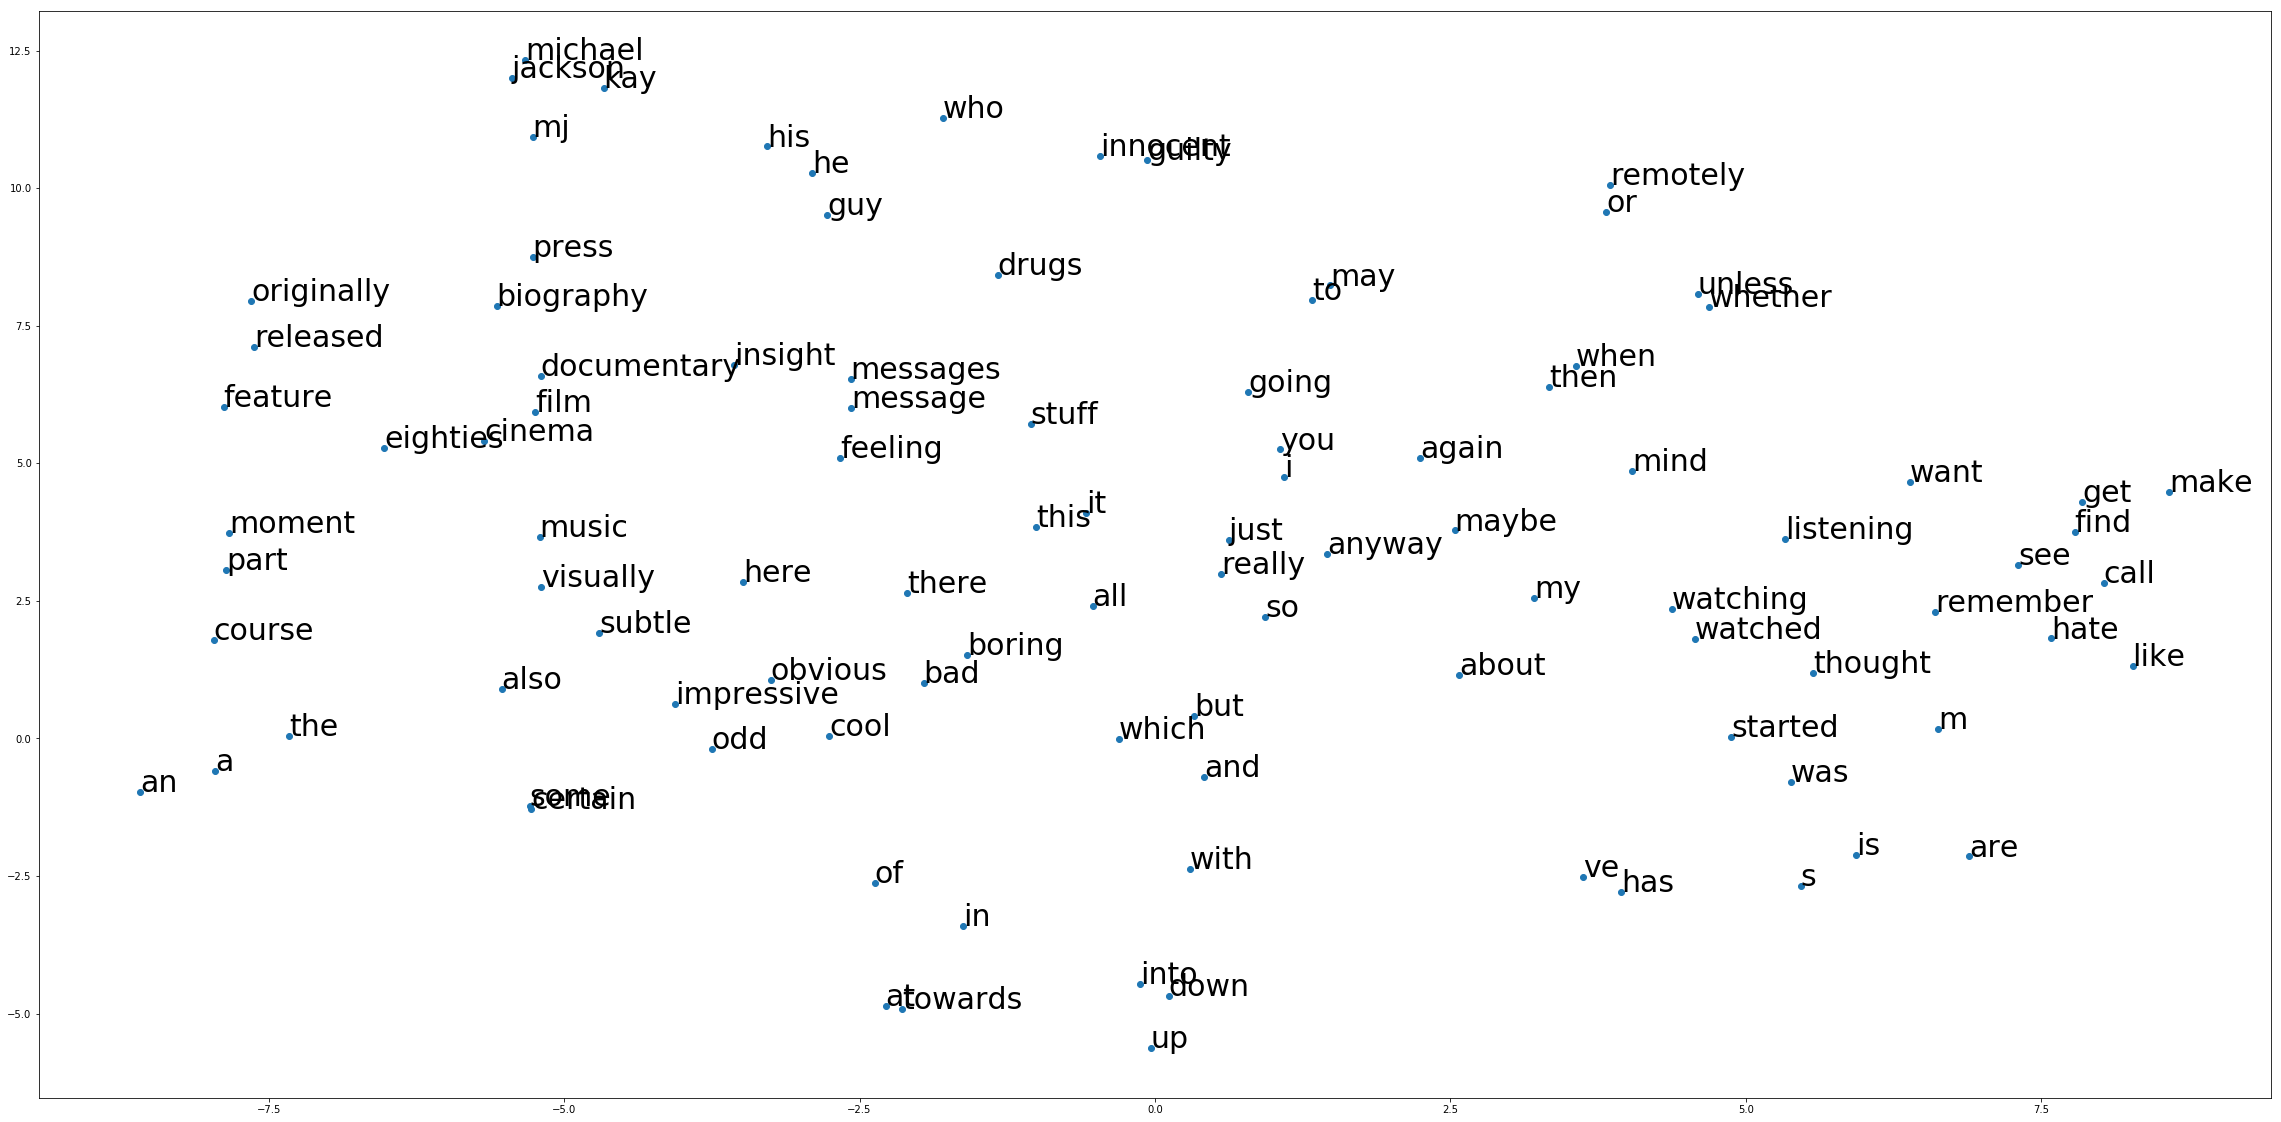

In [37]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(x='x',y='y',data=df)

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

# Numeric Representations of Words

In [57]:
model = Word2Vec.load("../saved_model/300features_40minwords_10context")
print(type(model.wv.syn0))
print(model.wv.syn0.shape)

2019-05-26 22:31:40,495 : INFO : loading Word2Vec object from ../saved_model/300features_40minwords_10context
2019-05-26 22:31:40,496 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-26 22:31:40,727 : INFO : loading wv recursively from ../saved_model/300features_40minwords_10context.wv.* with mmap=None
2019-05-26 22:31:40,728 : INFO : setting ignored attribute vectors_norm to None
2019-05-26 22:31:40,729 : INFO : loading vocabulary recursively from ../saved_model/300features_40minwords_10context.vocabulary.* with mmap=None
2019-05-26 22:31:40,729 : INFO : loading trainables recursively from ../saved_model/300features_40minwords_10context.trainables.* with mmap=None
2019-05-26 22:31:40,730 : INFO : setting ignored attribute cum_table to None
2019-05-26 22:31:40,730 : INFO : loaded ../saved_model/300features_40minwords_10context


<class 'numpy.ndarray'>
(16490, 300)


In [58]:
model_stem = Word2Vec.load("../saved_model/300features_40minwords_10context_add_stemming")
print(type(model_stem.wv.syn0))
print(model_stem.wv.syn0.shape)

2019-05-26 22:31:52,065 : INFO : loading Word2Vec object from ../saved_model/300features_40minwords_10context_add_stemming
2019-05-26 22:31:52,066 : WARNING : this function is deprecated, use smart_open.open instead
2019-05-26 22:31:52,236 : INFO : loading wv recursively from ../saved_model/300features_40minwords_10context_add_stemming.wv.* with mmap=None
2019-05-26 22:31:52,236 : INFO : setting ignored attribute vectors_norm to None
2019-05-26 22:31:52,237 : INFO : loading vocabulary recursively from ../saved_model/300features_40minwords_10context_add_stemming.vocabulary.* with mmap=None
2019-05-26 22:31:52,237 : INFO : loading trainables recursively from ../saved_model/300features_40minwords_10context_add_stemming.trainables.* with mmap=None
2019-05-26 22:31:52,237 : INFO : setting ignored attribute cum_table to None
2019-05-26 22:31:52,238 : INFO : loaded ../saved_model/300features_40minwords_10context_add_stemming


<class 'numpy.ndarray'>
(11986, 300)


In [59]:
def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화한다.
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.
    # Index2word는 모델의 사전에 있는 단어 명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 결과를 단어 수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.

    # 카운터를 초기화한다.
    counter = 0.
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")

    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, num_features)
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

In [60]:
# 멀티스레드로 8개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = KaggleWord2VecUtility.apply_by_multiprocessing(reviews["review"], KaggleWord2VecUtility.review_to_wordlist,workers=8)
    return clean_reviews

**Stemming 하지 않은 model**

In [135]:
%time clean_train_reviews = getCleanReviews(train)

Wall time: 12.8 s


In [136]:
%time trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features) 

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Wall time: 33 s


In [137]:
%time clean_test_reviews = getCleanReviews(test)

Wall time: 13 s


In [138]:
%time testDataVecs = getAvgFeatureVecs(clean_test_reviews, model, num_features)

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Wall time: 31.6 s


**Stemming 한 model**

In [139]:
%time clean_train_reviews_stem = getCleanReviews(train)

Wall time: 12.3 s


In [140]:
%time trainDataVecs_stem = getAvgFeatureVecs(clean_train_reviews_stem, model_stem, num_features) 

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Wall time: 32.3 s


In [141]:
%time clean_test_reviews_stem = getCleanReviews(test)

Wall time: 12 s


In [142]:
%time testDataVecs_stem = getAvgFeatureVecs(clean_test_reviews_stem, model_stem, num_features) 

Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Wall time: 31 s


In [65]:
print('trainDataVecs shape: ',trainDataVecs.shape)
print('testDataVecs shape: ',testDataVecs.shape)

print('trainDataVecs_stem shape: ',trainDataVecs_stem.shape)
print('testDataVecs_stem shape: ',testDataVecs_stem.shape)

trainDataVecs shape:  (25000, 300)
testDataVecs shape:  (25000, 300)
trainDataVecs_stem shape:  (25000, 300)
testDataVecs_stem shape:  (25000, 300)


# Model1: Random Forest

Model1 (stem X)

In [72]:
forest = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=2018)
%time forest = forest.fit( trainDataVecs, train["sentiment"] )

Wall time: 4.1 s


Model2 (stem O)

In [71]:
forest_stem = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=2018)
%time forest_stem = forest_stem.fit( trainDataVecs_stem, train["sentiment"] )

Wall time: 3.99 s


## Cross Validation

Model1 (stem X)

In [91]:
%time score = np.mean(cross_val_score(forest, trainDataVecs, train['sentiment'], cv=10, scoring='roc_auc'))
print('score: ',score)

Wall time: 39.6 s
score:  0.8652763199999999


Model2 (stem O)

In [97]:
%time score_stem = np.mean(cross_val_score(forest_stem, trainDataVecs_stem, train['sentiment'], cv=10, scoring='roc_auc'))
print('score_stem: ',score_stem)

Wall time: 39.8 s
score_stem:  0.904784064


## Test

binary

In [98]:
result = forest.predict( testDataVecs )
result_stem = forest_stem.predict( testDataVecs_stem )

In [99]:
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv('../submit/Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), index=False, quoting=3 )

output_stem = pd.DataFrame( data={"id":test["id"], "sentiment":result_stem} )
output_stem.to_csv('../submit/Word2Vec_AverageVectors_stem_{0:.5f}.csv'.format(score_stem), index=False, quoting=3 )

probs

In [100]:
result = forest.predict_proba( testDataVecs )
result_stem = forest_stem.predict_proba( testDataVecs_stem )

In [101]:
output_proba = pd.DataFrame( data={"id":test["id"], "sentiment":result[:,0]} )
output_proba.to_csv('../submit/Word2Vec_AverageVectors_proba_{0:.5f}.csv'.format(score), index=False, quoting=3 )

output_proba_stem = pd.DataFrame( data={"id":test["id"], "sentiment":result_stem[:,0]} )
output_proba_stem.to_csv('../submit/Word2Vec_AverageVectors_proba_stem_{0:.5f}.csv'.format(score_stem), index=False, quoting=3 )

## Train과 prediction간의 count 비교

Text(0.5, 1.0, 'Prediction stem O')

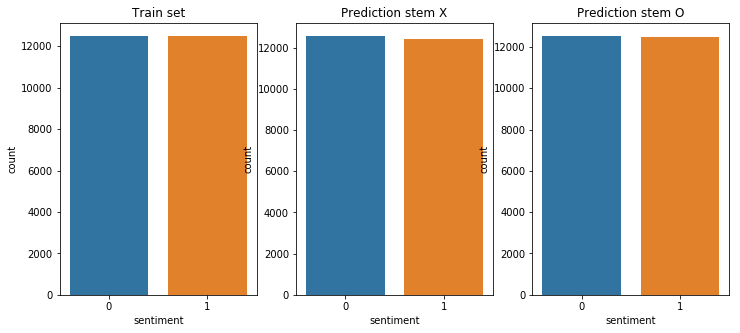

In [102]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=ax[0])
sns.countplot(output['sentiment'], ax=ax[1])
sns.countplot(output_stem['sentiment'], ax=ax[2])
ax[0].set_title('Train set')
ax[1].set_title('Prediction stem X')
ax[2].set_title('Prediction stem O')

## Public Leaderboard Score

Name | score 
-----|------
Word2Vec_AverageVectors_0.86528 | 0.78028
Word2Vec_AverageVectors_proba_stem0.90478 | 0.81984
Word2Vec_AverageVectors_proba_0.86528 | 0.85884
Word2Vec_AverageVectors_stem0.90478 | 0.89700

# From Words to Paragraphs, Attempt 2: Clustering 

- 군집별 평균 5개로 단어를 K-means를 통해서 분류한다. 
- ```idx```에 index별로 해당군집의 번호를 넣어준다. 
- 단어와 ```idx```를 매핑한다.
- 군집별 해당하는 단어를 출력한다.

In [104]:
num_clusters

3298.0

In [107]:
from sklearn.cluster import KMeans
import time

start = time.time() # Start time

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.syn0
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters , n_jobs=8)
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  213.38981699943542 seconds.


In [116]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.wv.index2word, idx ))

In [121]:
len(word_centroid_map.values())

16490

In [123]:
# For the first 10 clusters
for cluster in range(0,10):
    # Print the cluster number  
    print("\nCluster %d" % cluster)
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if list(word_centroid_map.values())[i] == cluster:
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['small', 'large', 'tiny', 'vast']

Cluster 1
['fanny', 'anais', 'tudor']

Cluster 2
['sent', 'sold', 'heading', 'invited', 'ordered', 'preparing', 'transported', 'transferred']

Cluster 3
['message', 'messages', 'quotes', 'statistics']

Cluster 4
['grandiose', 'collage', 'fanciful', 'dizzying', 'sprawling']

Cluster 5
['penguin', 'hitchhiker']

Cluster 6
['cars', 'buildings', 'vehicles', 'dusty', 'boats', 'landmarks', 'debris']

Cluster 7
['pigeon', 'ta']

Cluster 8
['international', 'canadian', 'australian', 'official', 'prestigious']

Cluster 9
['posing', 'anonymous', 'amoral', 'overnight', 'unscrupulous', 'myra', 'appointed', 'apache', 'impulse', 'idle', 'unsavory', 'ineffectual', 'trader', 'embittered', 'intrepid', 'upright', 'plucky', 'climber']


In [125]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # Return the "bag of centroids"
    return bag_of_centroids

위에서 정의한 ```create_bag_of_centroids``` 함수를 통해서 **각 리뷰별 단어를 나눈후 각 단어의 군집 번호를 생성**한다. 여기서 ```train_centroids```는 ```review 개수 X cluster 개수``` 이다. 

In [143]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros( (train["review"].size, num_clusters), dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews_stem:
    train_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

# Repeat for test reviews 
test_centroids = np.zeros(( test["review"].size, num_clusters), dtype="float32" )

counter = 0
for review in clean_test_reviews_stem:
    test_centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
    counter += 1

# Model2: Random Forest

In [150]:
# Fit a random forest and extract predictions 
forest = RandomForestClassifier(n_estimators = 100)

# Fitting the forest may take a few minutes
print("Fitting a random forest to labeled training data...")
forest = forest.fit(train_centroids, train["sentiment"])
result = forest.predict(test_centroids)
result_proba = forest.predict_proba(test_centroids)

Fitting a random forest to labeled training data...


## Cross Validation

In [148]:
%time score = np.mean(cross_val_score(forest, train_centroids, train['sentiment'], cv=10, scoring='roc_auc'))
print('score: ',score)

Wall time: 3min 10s
score:  0.8886747199999998


## Test

In [153]:
# Write the test results 
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("../submit/BagOfCentroids.csv", index=False, quoting=3 )

output = pd.DataFrame(data={"id":test["id"], "sentiment":result_proba[:,0]})
output.to_csv("../submit/BagOfCentroids_proba.csv", index=False, quoting=3 )

## Public Leaderboard Score

Name | score 
-----|------
BagOfCentroids | 0.80816
BagOfCentroids_proba | 0.88930